## 1. Import libraries

In [5]:
! pip install split-folders

In [1]:
import os
import cv2
import numpy as np
import matplotlib.cm as cm
import tensorflow as tf
import random
import PIL
from PIL import Image, ImageOps
import scipy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.applications import vgg16
from tensorflow.keras.applications import mobilenet
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.metrics import categorical_crossentropy

from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import splitfolders
%matplotlib inline

2022-09-12 13:15:17.399625: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/irene/tfm_env/tfm_env/lib/python3.8/site-packages/cv2/../../lib64:/home/irene/tfm_ros_ws/devel/lib:/opt/ros/noetic/lib:/opt/ros/noetic/lib/x86_64-linux-gnu:/home/irene/galactic_ws/install/yasmin_demo/lib:/home/irene/galactic_ws/install/yasmin_viewer/lib:/home/irene/galactic_ws/install/yasmin_ros/lib:/home/irene/galactic_ws/install/yasmin_interfaces/lib:/home/irene/galactic_ws/install/yasmin/lib:/home/irene/galactic_ws/install/simple_node/lib:/home/irene/galactic_ws/install/lcm/lib:/home/irene/galactic_ws/install/example_interfaces/lib:/home/irene/galactic_ws/install/example/lib:/home/irene/galactic_ws/install/audio_interfaces/lib:/home/irene/galactic_ws/install/a1_msgs/lib
2022-09-12 13:15:17.399776: I tensorflow/stream_executor/cuda/cu

## 2. Data preparation

In [25]:
splitfolders.ratio('rooms_dataset_simple', output="rooms_dataset_test", seed=30, ratio=(0.8, 0.1, 0.1)) 

In [58]:
os.listdir(f'rooms_dataset_test/train')  # Directory where training data folders are

['baño', 'exterior', 'zonas_comunes', 'zona_comercial', 'cocina', 'habitación']

In [59]:
num_classes = len(os.listdir(f'rooms_dataset_test/train'))
dataset_dir ="rooms_dataset_test"
batch_size = 32  # Training batch size
print(num_classes)

6


In [60]:
from keras.utils.data_utils import Sequence
from imblearn.over_sampling import RandomOverSampler
from imblearn.keras import balanced_batch_generator

class BalancedDataGenerator(Sequence):
    """ImageDataGenerator + RandomOversampling"""
    def __init__(self, x, y, datagen, batch_size=32):
        self.datagen = datagen
        self.batch_size = min(batch_size, x.shape[0])
        datagen.fit(x)
        self.gen, self.steps_per_epoch = balanced_batch_generator(x.reshape(x.shape[0], -1), y, sampler=RandomOverSampler(), batch_size=self.batch_size, keep_sparse=True)
        self._shape = (self.steps_per_epoch * batch_size, *x.shape[1:])
        
    def __len__(self):
        return self.steps_per_epoch

    def __getitem__(self, idx):
        x_batch, y_batch = self.gen.__next__()
        x_batch = x_batch.reshape(-1, *self._shape[1:])
        return self.datagen.flow(x_batch, y_batch, batch_size=self.batch_size).next()

In [61]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# preprocessing image and divide validaiton set
train_datagen = ImageDataGenerator(horizontal_flip=True, 
                                   brightness_range=[0.5,1.5], 
                                   zoom_range=[0.3,1], 
                                   rotation_range=5)

train_generator = train_datagen.flow_from_directory(dataset_dir+'/train',
                                                 target_size=(224,224),
                                                 batch_size=batch_size,
                                                 class_mode='categorical',
                                                 shuffle=True,
                                                 subset='training')

validation_datagen = ImageDataGenerator()

validation_generator = validation_datagen.flow_from_directory(dataset_dir+'/val',
                                                            target_size=(224,224),
                                                            batch_size=batch_size,
                                                            class_mode='categorical')

test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(dataset_dir+'/test',
                                                            target_size=(224,224),
                                                            batch_size=batch_size,
                                                            shuffle=False,
                                                            class_mode='categorical')



Found 815 images belonging to 6 classes.
Found 100 images belonging to 6 classes.
Found 106 images belonging to 6 classes.


In [7]:
train_classes = train_generator.classes

In [8]:
bgen = BalancedDataGenerator(X_train, y_train, train_datagen, batch_size=batch_size)
steps_per_epoch = bgen.steps_per_epoch

NameError: name 'X_train' is not defined

In [30]:
y_gen = [bgen.__getitem__(0)[1] for i in range(steps_per_epoch)]
print(np.unique(y_gen, return_counts=True))

(array([0., 1.], dtype=float32), array([160,  32]))


In [62]:
from sklearn.utils import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_classes),
                                        y = train_classes                                                    
                                    )
class_weights = dict(zip(np.unique(train_classes), class_weights))
class_weights

{0: 1.2020648967551621,
 1: 2.263888888888889,
 2: 0.5854885057471264,
 3: 0.4921497584541063,
 4: 2.829861111111111,
 5: 1.5794573643410852}

In [63]:
classes = train_generator.class_indices
print(classes)

{'baño': 0, 'cocina': 1, 'exterior': 2, 'habitación': 3, 'zona_comercial': 4, 'zonas_comunes': 5}


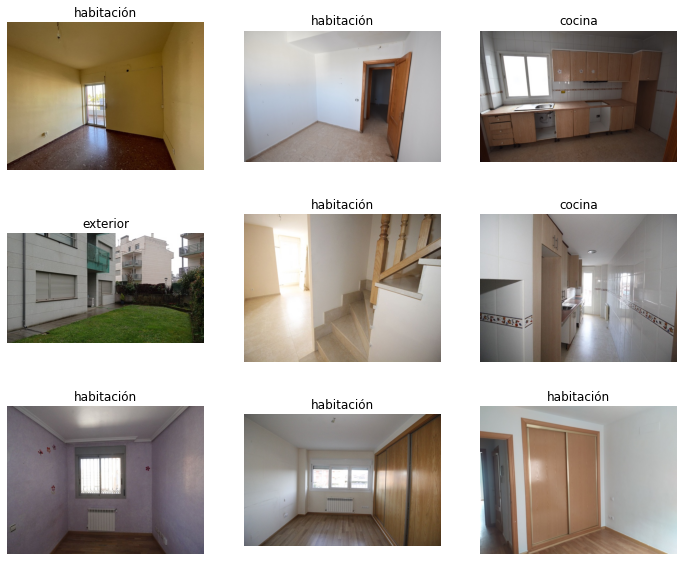

In [64]:
class_names = list(classes.keys())

fig, axes = plt.subplots(3,3, figsize=(12, 10))
indices = np.random.randint(0, 624, size=9)
for i, ax in enumerate(axes.flatten()):
    indx = indices[i]
    im = Image.open(train_generator.filepaths[indx])
    ax.imshow(im)
    ax.set_title(class_names[train_generator.classes[indx]])
    ax.axis('off')

## 3. Download network

In [65]:
#Get the places356 weights
weights_file = 'vgg16-places365_weights_tf_dim_ordering_tf_kernels_notop.h5'
weights_path = tf.keras.utils.get_file(weights_file, 'https://github.com/GKalliatakis/Keras-VGG16-places365/releases/download/v1.0/vgg16-places365_weights_tf_dim_ordering_tf_kernels_notop.h5')

In [66]:
base_model = vgg16.VGG16(weights = weights_path , include_top=False, input_shape = (224, 224, 3))
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [67]:
# iterate through its layers and lock them to make them not trainable with this code
for layer in base_model.layers:
    layer.trainable = False

#ine_tune=2
#if fine_tune es decir cuantas capas quieres reentrenar
#or layer in base_model.layers[:-fine_tune]:
#   layer.trainable = False

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [68]:
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# save the output of the last layer to be the input of the next layer
last_layer = base_model.output
print(last_layer)

# flatten the classifier input which is output of the last layer of VGG16 model
#x = Flatten(name="flatten")(last_layer)
x = GlobalAveragePooling2D()(last_layer)

# add two FC layers, 50 and 20 units and relu activation 
x = Dense(50, activation='relu')(x)
x = Dense(30, activation='relu')(x)

x = Dense(num_classes, activation='softmax', name='softmax')(x)

# instantiate a new_model using keras’s Model class
new_model = Model(inputs=base_model.input, outputs=x)
vgg_model = Model(inputs=base_model.input, outputs=x)
# print the new_model summary
new_model.summary()


KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 512), dtype=tf.float32, name=None), name='block5_pool/MaxPool:0', description="created by layer 'block5_pool'")
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)     

In [69]:
#new_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
new_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [70]:
from livelossplot.inputs.keras import PlotLossesCallback
plot_loss = PlotLossesCallback()

In [71]:
import math
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend as K

early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

checkpoint = ModelCheckpoint('logs/ep{epoch:03}-val_accuracy{val_accuracy:.3f}.h5', monitor='val_accuracy',save_best_only=True, verbose=1)

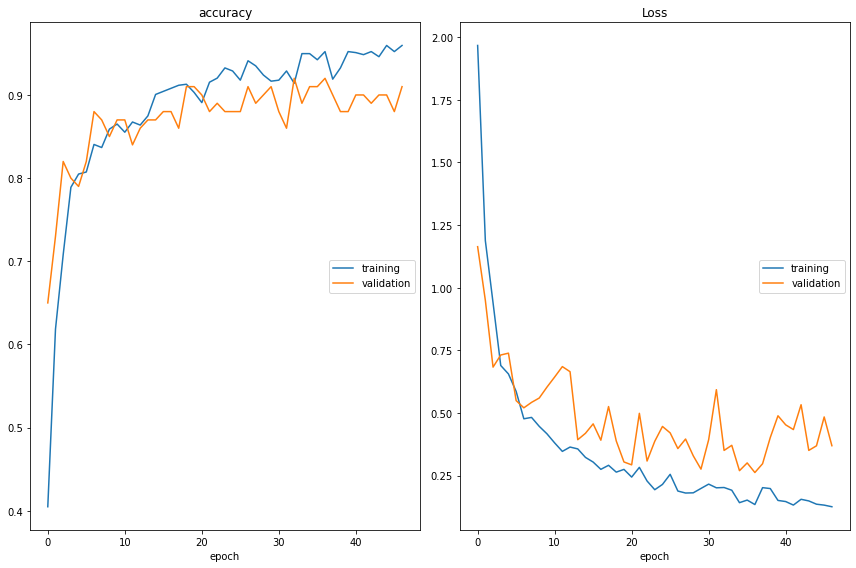

accuracy
	training         	 (min:    0.405, max:    0.960, cur:    0.960)
	validation       	 (min:    0.650, max:    0.920, cur:    0.910)
Loss
	training         	 (min:    0.126, max:    1.967, cur:    0.126)
	validation       	 (min:    0.263, max:    1.164, cur:    0.370)
26/26 - 149s - loss: 0.1260 - accuracy: 0.9595 - val_loss: 0.3695 - val_accuracy: 0.9100 - 149s/epoch - 6s/step


In [72]:
history = new_model.fit(train_generator, class_weight=class_weights, batch_size=batch_size, validation_data=validation_generator, epochs=100, verbose=2, callbacks=[checkpoint, early_stop, plot_loss])

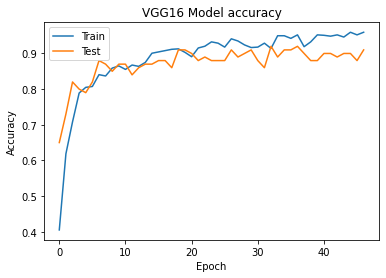

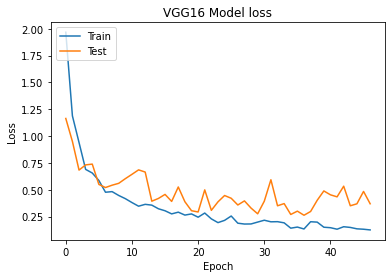

In [73]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('VGG16 Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('VGG16 Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [74]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = new_model.predict_generator(test_generator, 211 // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=class_names))

#Evaluating using Keras model_evaluate:
x, y = zip(*(test_generator[i] for i in range(len(test_generator))))
x_test, y_test = np.vstack(x), np.vstack(y)
loss, acc = new_model.evaluate(x_test, y_test, batch_size=32)

print("Accuracy: " ,acc)
print("Loss: ", loss)

/tmp/ipykernel_27635/1791578091.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = new_model.predict_generator(test_generator, 211 // batch_size+1)


Confusion Matrix
[[15  0  0  0  0  0]
 [ 0  6  1  2  0  0]
 [ 1  0 28  0  0  0]
 [ 1  0  1 31  0  2]
 [ 0  0  0  0  6  0]
 [ 1  1  1  2  0  7]]
Classification Report
                precision    recall  f1-score   support

          baño       0.83      1.00      0.91        15
        cocina       0.86      0.67      0.75         9
      exterior       0.90      0.97      0.93        29
    habitación       0.89      0.89      0.89        35
zona_comercial       1.00      1.00      1.00         6
 zonas_comunes       0.78      0.58      0.67        12

      accuracy                           0.88       106
     macro avg       0.88      0.85      0.86       106
  weighted avg       0.87      0.88      0.87       106

4/4 [==============================] - 17s 4s/step - loss: 0.5178 - accuracy: 0.8774
Accuracy:  0.8773584961891174
Loss:  0.51780766248703


In [49]:
new_model.save("logs/model_rmsprop_gap_acc89.h5")

In [50]:
# Generate predictions
true_classes = test_generator.classes
class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

preloaded_weights = []
for pre in new_model.layers:
    preloaded_weights.append(pre.get_weights())

# load pre-trained weights
vgg_model.load_weights('logs/ep015-val_accuracy0.920.h5', by_name=True) # initialize the best trained weights

# compare previews weights vs loaded weights
for layer, pre in zip(vgg_model.layers, preloaded_weights):
    weights = layer.get_weights()

    if weights:
        if np.array_equal(weights, pre):
            print('not loaded', layer.name)
        else:
            print('loaded', layer.name)


loaded block1_conv1
loaded block1_conv2
loaded block2_conv1
loaded block2_conv2
loaded block3_conv1
loaded block3_conv2
loaded block3_conv3
loaded block4_conv1
loaded block4_conv2
loaded block4_conv3
loaded block5_conv1
loaded block5_conv2
loaded block5_conv3
loaded dense_2
loaded dense_3
loaded softmax


/home/irene/tfm_env/tfm_env/lib/python3.8/site-packages/numpy/core/numeric.py:2457: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a1, a2 = asarray(a1), asarray(a2)


In [66]:
from sklearn.metrics import accuracy_score

y_pred = vgg_model.predict(x_test, batch_size=32)
y_pred1D = y_pred.argmax(1)
y_test1D = y_test.argmax(1)
test_accuracy = accuracy_score(y_test1D, y_pred1D)
print("VGG16 Model Accuracy without Fine-Tuning: {:.2f}%".format(test_accuracy * 100))

4/4 [==============================] - 17s 4s/step
VGG16 Model Accuracy without Fine-Tuning: 85.85%


### Fine-tuning

In [51]:
# Reset our image data generators
train_generator.reset()
validation_generator.reset()
test_generator.reset()

In [52]:
from tensorflow.keras.models import clone_model
base_model= clone_model(new_model)
base_model.build(new_model.input) # replace 10 with number of variables in input layer
base_model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
base_model.set_weights(new_model.get_weights())

In [25]:
from tensorflow.keras.models import clone_model
base_model= clone_model(new_model)
base_model.build(new_model.input) # replace 10 with number of variables in input layer
base_model.compile(optimizer='adam', loss='categorical_crossentropy')
base_model.set_weights(new_model.get_weights())

In [53]:
base_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [54]:
fine_tune=10
for layer in base_model.layers[-fine_tune:]:
    print(layer.name)
    layer.trainable = True

base_model.summary()

block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool
global_average_pooling2d
dense_2
dense_3
softmax
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    


In [55]:
plot_loss_ft = PlotLossesCallback()

In [56]:
base_model.compile(optimizer=RMSprop(learning_rate=1e-7), loss='categorical_crossentropy', metrics=['accuracy'])
#base_model.compile(optimizer=Adam(learning_rate=1e-7), loss='categorical_crossentropy', metrics=['accuracy'])

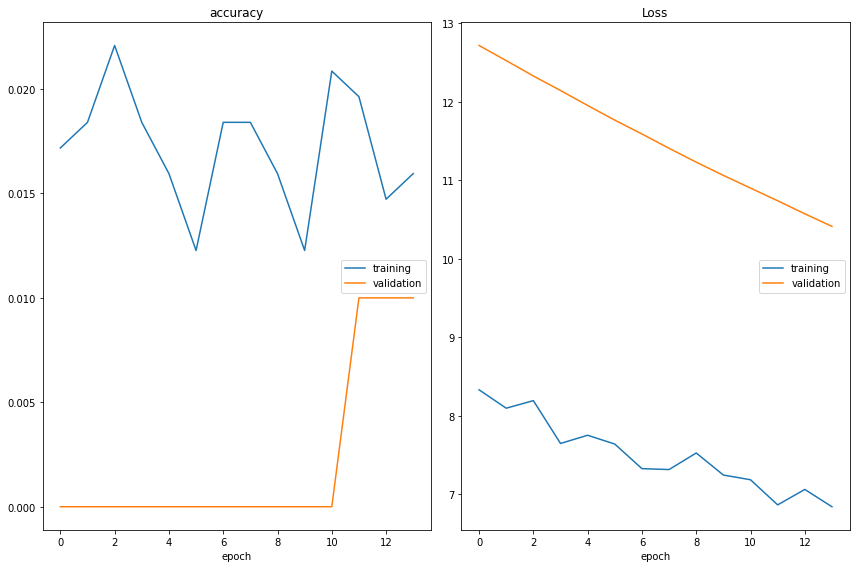

accuracy
	training         	 (min:    0.012, max:    0.022, cur:    0.016)
	validation       	 (min:    0.000, max:    0.010, cur:    0.010)
Loss
	training         	 (min:    6.841, max:    8.331, cur:    6.841)
	validation       	 (min:   10.413, max:   12.718, cur:   10.413)
26/26 - 206s - loss: 6.8407 - accuracy: 0.0160 - val_loss: 10.4128 - val_accuracy: 0.0100 - 206s/epoch - 8s/step
Epoch 15/20


KeyboardInterrupt: 

In [57]:
history = base_model.fit(train_generator, batch_size=batch_size, class_weight=class_weights, validation_data=validation_generator, epochs=20, verbose=2, callbacks=[checkpoint, plot_loss_ft])

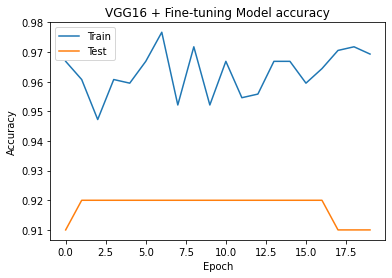

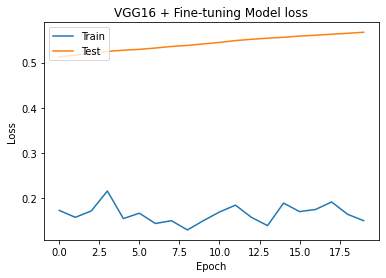

In [31]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('VGG16 + Fine-tuning Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('VGG16 + Fine-tuning Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [77]:
base_model.save("logs/model_ft_balanced_adam_flatten.h5")

In [33]:
test_generator.reset()

/tmp/ipykernel_27635/3168272075.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = base_model.predict_generator(test_generator, 106 // batch_size+1)


Confusion Matrix
[[15  0  0  0  0  0]
 [ 0  6  0  2  0  1]
 [ 0  1 28  0  0  0]
 [ 0  0  1 32  0  2]
 [ 0  0  0  0  5  1]
 [ 0  2  0  1  0  9]]


/tmp/ipykernel_27635/3168272075.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + class_names)
/tmp/ipykernel_27635/3168272075.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + class_names)


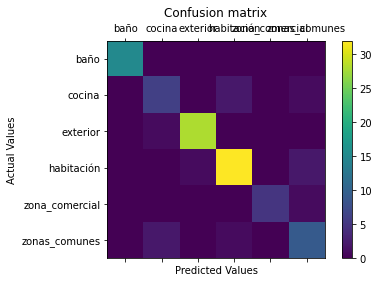

Classification Report
                precision    recall  f1-score   support

          baño       1.00      1.00      1.00        15
        cocina       0.67      0.67      0.67         9
      exterior       0.97      0.97      0.97        29
    habitación       0.91      0.91      0.91        35
zona_comercial       1.00      0.83      0.91         6
 zonas_comunes       0.69      0.75      0.72        12

      accuracy                           0.90       106
     macro avg       0.87      0.85      0.86       106
  weighted avg       0.90      0.90      0.90       106

4/4 [==============================] - 17s 4s/step - loss: 0.6157 - accuracy: 0.8962
Accuracy:  0.8962264060974121
Loss:  0.6157310009002686


In [34]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = base_model.predict_generator(test_generator, 106 // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(test_generator.classes, y_pred)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix')
fig.colorbar(cax)
ax.set_xticklabels([''] + class_names)
ax.set_yticklabels([''] + class_names)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=class_names))

#Evaluating using Keras model_evaluate:
x, y = zip(*(test_generator[i] for i in range(len(test_generator))))
x_test, y_test = np.vstack(x), np.vstack(y)
loss, acc = base_model.evaluate(x_test, y_test, batch_size=32)

print("Accuracy: " ,acc)
print("Loss: ", loss)

In [79]:
# Generate predictions
true_classes = test_generator.classes
class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

preloaded_weights = []
for pre in new_model.layers:
    preloaded_weights.append(pre.get_weights())

# load pre-trained weights
vgg_model.load_weights('logs/model_ft_balanced.h5') # initialize the best trained weights

# compare previews weights vs loaded weights
for layer, pre in zip(vgg_model.layers, preloaded_weights):
    weights = layer.get_weights()

    if weights:
        if np.array_equal(weights, pre):
            print('not loaded', layer.name)
        else:
            print('loaded', layer.name)


loaded block1_conv1
loaded block1_conv2
loaded block2_conv1
loaded block2_conv2
loaded block3_conv1
loaded block3_conv2
loaded block3_conv3
loaded block4_conv1
loaded block4_conv2
loaded block4_conv3
loaded block5_conv1
loaded block5_conv2
loaded block5_conv3
loaded dense_4
loaded dense_5
loaded softmax


/home/irene/tfm_env/tfm_env/lib/python3.8/site-packages/numpy/core/numeric.py:2457: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a1, a2 = asarray(a1), asarray(a2)


In [62]:
from tensorflow.python.tools import freeze_graph
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

# Convert Keras model to ConcreteFunction
full_model = tf.function(lambda x: vgg_model(x))
full_model = full_model.get_concrete_function(
    tf.TensorSpec(vgg_model.inputs[0].shape, vgg_model.inputs[0].dtype, name='indoor_model'))
# Get frozen ConcreteFunction
frozen_func = convert_variables_to_constants_v2(full_model)
frozen_func.graph.as_graph_def()
layers = [op.name for op in frozen_func.graph.get_operations()]

# Save frozen graph from frozen ConcreteFunction to hard drive
tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
                  logdir="./91_model",
                  name="frozen_graph_indoor.pb",
                  as_text=False)

2022-09-07 21:16:07.599482: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2022-09-07 21:16:07.599847: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session


'./91_model/frozen_graph_indoor.pb'

In [80]:
from sklearn.metrics import accuracy_score

y_pred = vgg_model.predict(x_test, batch_size=32)
y_pred1D = y_pred.argmax(1)
y_test1D = y_test.argmax(1)
test_accuracy = accuracy_score(y_test1D, y_pred1D)
print("VGG16 Model Accuracy with Fine-Tuning: {:.2f}%".format(test_accuracy * 100))

4/4 [==============================] - 18s 4s/step
VGG16 Model Accuracy with Fine-Tuning: 84.91%


In [29]:
files=test_generator.filenames
class_dict=test_generator.class_indices # a dictionary of the form class name: class index
rev_dict={}
for key, value in class_dict.items():
    rev_dict[value]=key   # dictionary of the form class index: class name
    
print(rev_dict)

{0: 'baño', 1: 'cocina', 2: 'exterior', 3: 'habitación', 4: 'zona_comercial', 5: 'zonas_comunes'}


In [30]:
predictions = vgg_model.predict(test_generator)

4/4 [==============================] - 18s 4s/step


In [32]:
for i, p in enumerate(predictions):
    index=np.argmax(p)
    klass=rev_dict[index]    
    prob=p[index]
    print('for file ', files[i], ' predicted class is ', klass,' with probability ',prob)

for file  baño/baño (1).jpeg  predicted class is  baño  with probability  0.99999994
for file  baño/baño (102).JPG  predicted class is  baño  with probability  0.99999994
for file  baño/baño (103).JPG  predicted class is  baño  with probability  0.99999994
for file  baño/baño (11).jpeg  predicted class is  baño  with probability  0.99999994
for file  baño/baño (14).JPG  predicted class is  baño  with probability  0.99999994
for file  baño/baño (15).JPG  predicted class is  baño  with probability  0.99999994
for file  baño/baño (21).jpeg  predicted class is  baño  with probability  0.7184831
for file  baño/baño (3).jpeg  predicted class is  baño  with probability  0.99999994
for file  baño/baño (34).JPG  predicted class is  baño  with probability  0.99999994
for file  baño/baño (35).jpeg  predicted class is  baño  with probability  0.99999994
for file  baño/baño (42).JPG  predicted class is  baño  with probability  0.9939394
for file  baño/baño (60).JPG  predicted class is  baño  with p